<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest Regression 
</p>

In [2]:
# Libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model building and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
)
from itertools import product

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [4]:
# Path to the standardized database directory
base_path = '../../Comprehensive ML - Files & Plots etc.'

# Load train and test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

# (Optional: For plotting)
time_train = df_train['time'].values
time_test = df_test['time'].values

# Load 5-fold assignments
fold_assignments = np.load(f"{base_path}/train_folds.npy")

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))
print('\nDataset loaded successfully!\n')


Training samples: 1132523, Test samples: 283131
{np.int64(0): np.int64(226505), np.int64(1): np.int64(226505), np.int64(2): np.int64(226505), np.int64(3): np.int64(226504), np.int64(4): np.int64(226504)}

Dataset loaded successfully!



<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Grid and Helper Functions
</p>

In [6]:
# Define hyperparameter options
max_depth_values = list(range(2, 26))  # [2, 3, ..., 100]
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 10, 20, 50, 80, 100],
    'min_samples_leaf': [1, 2, 4, 10, 20, 50, 100, 200, 500],
}

# Number of random candidates to sample (changeable!)
n_random_samples = 15  # e.g., 15 random samples per max_depth

# Helper: generate all possible candidates, then randomly sample
all_candidates = list(product(
    param_grid['n_estimators'],
    max_depth_values,
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
))
print(f"Full grid has {len(all_candidates)} candidates.")

np.random.seed(42)
random_indices = np.random.choice(len(all_candidates), size=n_random_samples, replace=False)
random_combos = [all_candidates[i] for i in random_indices]
print(f"Random search: trying {len(random_combos)} candidates.")

def create_rf_model(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    return RandomForestRegressor(
        n_estimators=n_estimators,
        criterion='squared_error',
        max_depth=max_depth,
        max_features='log2',
        random_state=50,
        n_jobs=-1,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=0.01,
        bootstrap=True,
        oob_score=False
    )

Full grid has 3888 candidates.
Random search: trying 15 candidates.


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Grid Search with 5-Fold CV 
</p>

In [8]:
# Results for best-per-depth reporting/plotting 
cv_summary_per_depth = []
cv_results_all = []

for max_depth in max_depth_values:
    print(f"\nPerforming Random Search for max_depth={max_depth}...")
    # Filter random candidates for this depth
    candidates = [combo for combo in random_combos if combo[1] == max_depth]
    print(f"Fitting 5 folds for each of {len(candidates)} candidates, totalling {len(candidates)*5} fits")
    best_mean_rmse = np.inf
    best_params = None
    best_mean_r2 = None
    best_std_r2 = None
    best_std_rmse = None

    for n_estimators, max_depth_here, min_samples_split, min_samples_leaf in candidates:
        fold_rmse = []
        fold_r2 = []
        for fold_num in range(5):
            tr_idx = np.where(fold_assignments != fold_num)[0]
            val_idx = np.where(fold_assignments == fold_num)[0]
            X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
            X_val, y_val = X_train[val_idx], y_train[val_idx]
            rf = create_rf_model(n_estimators, max_depth_here, min_samples_split, min_samples_leaf)
            rf.fit(X_tr, y_tr)
            y_val_pred = rf.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            r2 = r2_score(y_val, y_val_pred)
            fold_rmse.append(rmse)
            fold_r2.append(r2)
        mean_cv_rmse = np.mean(fold_rmse)
        std_cv_rmse = np.std(fold_rmse)
        mean_cv_r2 = np.mean(fold_r2)
        std_cv_r2 = np.std(fold_r2)

        cv_results_all.append({
            'max_depth': max_depth_here,
            'n_estimators': n_estimators,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'mean_rmse': mean_cv_rmse,
            'std_rmse': std_cv_rmse,
            'mean_r2': mean_cv_r2,
            'std_r2': std_cv_r2
        })

        if mean_cv_rmse < best_mean_rmse:
            best_mean_rmse = mean_cv_rmse
            best_std_rmse = std_cv_rmse
            best_params = {
                'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf
            }
            best_mean_r2 = mean_cv_r2
            best_std_r2 = std_cv_r2

    # Only print and record if a candidate exists for this depth
    if best_params is not None:
        print(f"Best Parameters for max_depth={max_depth}: {best_params}")
        print(f"Best CV RMSE for max_depth={max_depth}: {best_mean_rmse:.4f}")
        print(f"STD of CV RMSE for max_depth={max_depth}: {best_std_rmse:.4f}")
        print(f"Best CV R² for max_depth={max_depth}: {best_mean_r2:.4f}")
        print(f"STD of CV R² for max_depth={max_depth}: {best_std_r2:.4f}")
    else:
        print(f"No candidates for max_depth={max_depth}")
        
    cv_summary_per_depth.append({
        'max_depth': max_depth,
        'best_cv_rmse': best_mean_rmse,
        'std_cv_rmse': best_std_rmse,
        'best_cv_r2': best_mean_r2,
        'std_cv_r2': best_std_r2,
        'best_params': best_params
    })

cv_df = pd.DataFrame(cv_summary_per_depth)
cv_results_df = pd.DataFrame(cv_results_all)


Performing Random Search for max_depth=2...
Fitting 5 folds for each of 0 candidates, totalling 0 fits
No candidates for max_depth=2

Performing Random Search for max_depth=3...
Fitting 5 folds for each of 0 candidates, totalling 0 fits
No candidates for max_depth=3

Performing Random Search for max_depth=4...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for max_depth=4: {'n_estimators': 100, 'min_samples_split': 80, 'min_samples_leaf': 50}
Best CV RMSE for max_depth=4: 6.7147
STD of CV RMSE for max_depth=4: 0.0243
Best CV R² for max_depth=4: 0.8763
STD of CV R² for max_depth=4: 0.0007

Performing Random Search for max_depth=5...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters for max_depth=5: {'n_estimators': 200, 'min_samples_split': 80, 'min_samples_leaf': 50}
Best CV RMSE for max_depth=5: 6.1276
STD of CV RMSE for max_depth=5: 0.0227
Best CV R² for max_depth=5: 0.8970
STD of CV R² for max_depth=5: 0.0007

Performing Random 

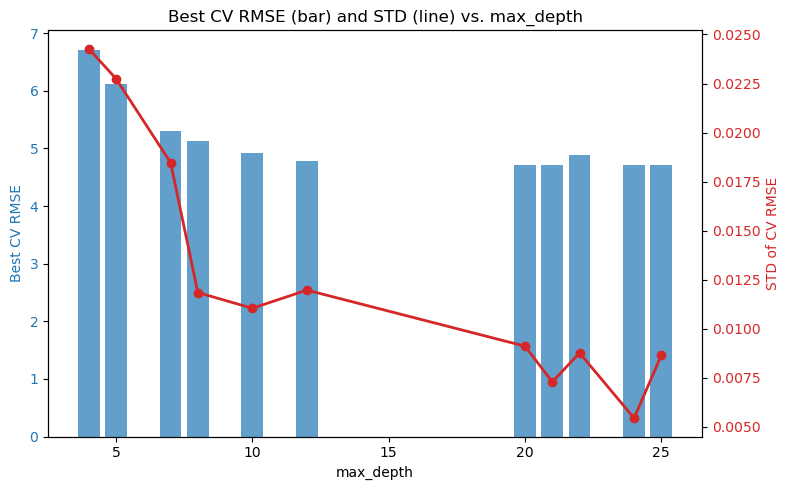

In [9]:
# Filter out rows with missing best_cv_rmse (or std_cv_rmse)
plot_df = cv_df.dropna(subset=['best_cv_rmse', 'std_cv_rmse'])

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Best CV RMSE', color='tab:blue')
ax1.bar(plot_df['max_depth'], plot_df['best_cv_rmse'], color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('STD of CV RMSE', color='tab:red')
ax2.plot(plot_df['max_depth'], plot_df['std_cv_rmse'], color='tab:red', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Best CV RMSE (bar) and STD (line) vs. max_depth')
fig.tight_layout()
plt.show()

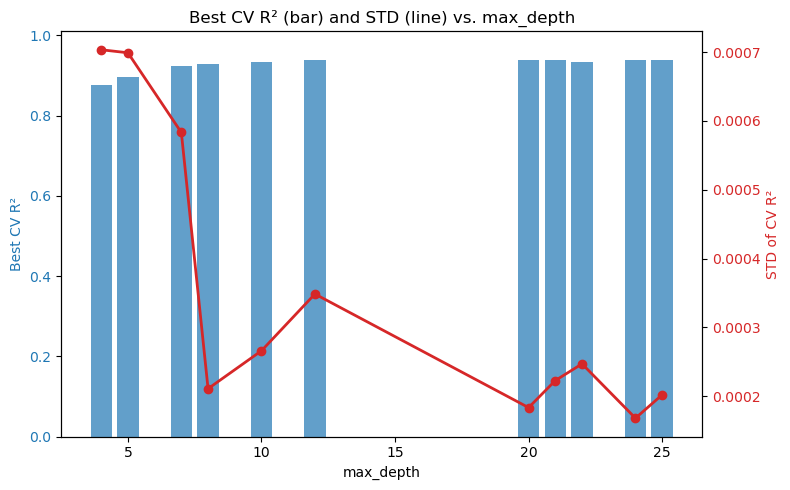

In [10]:
# Filter out rows with missing best_cv_r2 or std_cv_r2
plot_df = cv_df.dropna(subset=['best_cv_r2', 'std_cv_r2'])

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Best CV R²', color='tab:blue')
ax1.bar(plot_df['max_depth'], plot_df['best_cv_r2'], color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1.01)

ax2 = ax1.twinx()
ax2.set_ylabel('STD of CV R²', color='tab:red')
ax2.plot(plot_df['max_depth'], plot_df['std_cv_r2'], color='tab:red', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Best CV R² (bar) and STD (line) vs. max_depth')
fig.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [12]:
best_row = cv_results_df.sort_values('mean_rmse').iloc[0]
print("Best Parameters Found:")
print(best_row)

rf_model = create_rf_model(
    int(best_row['n_estimators']),
    int(best_row['max_depth']),
    int(best_row['min_samples_split']),
    int(best_row['min_samples_leaf'])
)
print("\nTraining Random Forest model on all training data...")
rf_model.fit(X_train, y_train)
print("\nTraining Completed!\n")

# Predict on train and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

Best Parameters Found:
max_depth             25.000000
n_estimators         300.000000
min_samples_split     50.000000
min_samples_leaf      10.000000
mean_rmse              4.710037
std_rmse               0.008647
mean_r2                0.939144
std_r2                 0.000202
Name: 14, dtype: float64

Training Random Forest model on all training data...

Training Completed!


Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),22.140561
1,Test Loss (MSE),22.074335
2,Test RMSE,4.698333
3,R² Score (Test),0.939165
4,Test MAPE (%),4.104647
5,Test Median AE,2.851661
